In [1]:
from typing import Callable, Tuple
from finite_distributions.FiniteDistribution import FiniteDistribution
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sinkhorn.SinkhornRunner as SinkhornRunner
import sinkhorn.SinkhornKernels as skern
import visualizer.joint_distribution_visualizer as jdv
import pandas as pd

In [2]:
def gaussian_prob(mu: float, sigma: float, x: float):
    return np.exp(-(x - mu)**2 / (2 * sigma * sigma))

In [3]:
mu_1 = -0.0
sigma_1 = 1.0

mu_2 = 0.0
sigma_2 = np.sqrt(2)

In [4]:
def unregularized_transport_map(x: float) -> float:
    return mu_2 + (x - mu_1) * (sigma_2/sigma_1)

In [5]:
xs = [round(x, 5) for x in np.linspace(-5, 5, 50)]

In [6]:
s1 = np.sum([gaussian_prob(mu_1, sigma_1, x) for x in xs])
s2 = np.sum([gaussian_prob(mu_2, sigma_2, x) for x in xs])

dist_1 = FiniteDistribution({x: gaussian_prob(mu_1, sigma_1, x) / s1 for x in xs})
dist_2 = FiniteDistribution({x: gaussian_prob(mu_2, sigma_2, x) / s2 for x in xs})

In [ ]:
c = lambda x, y: 0.5*(x - y)**2

In [8]:
def unregularized_transport_map(x: float) -> float:
    return mu_2 + (x - mu_1) * (sigma_2/sigma_1)

In [9]:
# p-norm
sinkhorn_runner = skern.get_quadratically_regularized_runner(c, use_parallelization=False)
# entropic
sinkhorn_runner_entropic = skern.get_entropically_regularized_runner(c)


epsilons_q = np.linspace(np.power(10.0, -3.0), np.power(10.0, 1.0), 500)
epsilons_e = [epsilon for epsilon in epsilons_q if epsilon > 1e-2]

delta = 0.01

distribution_outputs_quadratic = {}
for epsilon in reversed(epsilons_q):
    print(f"Running Quadratic, epsilon = {epsilon}")
    pi_p, f_p, g_p, iterations, outer_iterations = sinkhorn_runner.run_sinkhorn(dist_1, dist_2, epsilon, delta)
    distribution_outputs_quadratic[epsilon] = (pi_p, f_p, g_p, iterations, outer_iterations)
    print(f"Done with Quadratic, epsilon = {epsilon}. Inner iterations: {iterations}. Outer iterations: {outer_iterations}")

print("Done with quadratic.")

distribution_outputs_entropic = {}
for epsilon in reversed(epsilons_e):
    print(f"Running Entropic, epsilon = {epsilon}")
    _, _, _, _, iterations_outer_previous = distribution_outputs_quadratic[epsilon]
    pi_p, f_p, g_p, iterations, outer_iterations = sinkhorn_runner_entropic.run_sinkhorn(dist_1, dist_2, epsilon, delta)
    distribution_outputs_entropic[epsilon] = (pi_p, f_p, g_p, iterations, outer_iterations)
    print(f"Done with Entropic, epsilon = {epsilon}. Inner iterations: {iterations}. Outer iterations: {outer_iterations}")

print("Done with entropic.")

Running Quadratic, epsilon = 10.0
Done with Quadratic, epsilon = 10.0. Inner iterations: 3372. Outer iterations: 1
Running Quadratic, epsilon = 9.979961923847696
Done with Quadratic, epsilon = 9.979961923847696. Inner iterations: 3370. Outer iterations: 1
Running Quadratic, epsilon = 9.959923847695391
Done with Quadratic, epsilon = 9.959923847695391. Inner iterations: 3368. Outer iterations: 1
Running Quadratic, epsilon = 9.939885771543088
Done with Quadratic, epsilon = 9.939885771543088. Inner iterations: 3366. Outer iterations: 1
Running Quadratic, epsilon = 9.919847695390782
Done with Quadratic, epsilon = 9.919847695390782. Inner iterations: 3364. Outer iterations: 1
Running Quadratic, epsilon = 9.899809619238477
Done with Quadratic, epsilon = 9.899809619238477. Inner iterations: 3362. Outer iterations: 1
Running Quadratic, epsilon = 9.879771543086173
Done with Quadratic, epsilon = 9.879771543086173. Inner iterations: 3362. Outer iterations: 1
Running Quadratic, epsilon = 9.85973346

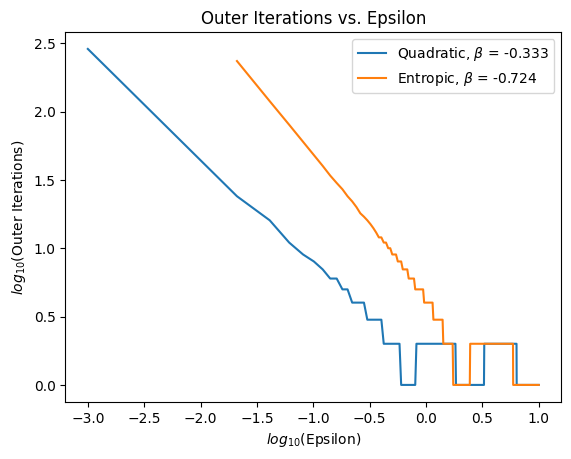

In [54]:
plt.figure()

xs_q = np.log10(epsilons_q)
xs_e = np.log10(epsilons_e)

ys_q = np.log10(np.array([distribution_outputs_quadratic[epsilon][4] for epsilon in epsilons_q]))
ys_e = np.log10(np.array([distribution_outputs_entropic[epsilon][4] for epsilon in epsilons_e]))

var_x_q = np.mean(xs_q * xs_q) - np.mean(xs_q)**2
cov_q = np.mean(ys_q * xs_q) - np.mean(ys_q)*np.mean(xs_q)

var_x_e = np.mean(xs_e*xs_e) - np.mean(xs_e)**2
cov_e = np.mean(ys_e * xs_e) - np.mean(ys_e)*np.mean(xs_e)

beta_q = cov_q / var_x_q
beta_e = cov_e / var_x_e

plt.plot(xs_q, ys_q, label = f"Quadratic, $\\beta$ = {round(beta_q, 3)}")
plt.plot(xs_e, ys_e, label = f"Entropic, $\\beta$ = {round(beta_e, 3)}")
plt.xlabel("$log_{10}$(Epsilon)")
plt.ylabel("$log_{10}$(Outer Iterations)")
plt.title("Outer Iterations vs. Epsilon")
plt.legend()
plt.savefig('./plots/log_epsilon_vs_outer_iterations.png', dpi=300)
plt.show()

In [ ]:
# now we calculate the maxmimum width of support around each point. 
epsilon_threshold_entropic = 1e-12 # cutoff, since entropic has full support
deminimis = 1e-12 # floating-point rouding cutoff
max_diams_quadratic = []
max_diams_entropic = []

for epsilon in epsilons_q:
    valid_entropic = epsilon in epsilons_e
    (pi_q, _, _, _, _) = distribution_outputs_quadratic[epsilon]
    if valid_entropic:
        (pi_e, _, _, _, _) = distribution_outputs_entropic[epsilon]
    max_quadratic = 0.0
    max_entropic = 0.0
    for x in dist_1.get_keys():
        maxmin_quadratic = [np.inf, -np.inf]
        maxmin_entropic = [np.inf, -np.inf]
        for y in dist_2.get_keys():
            if pi_q.get_probability((x, y)) > deminimis:
                maxmin_quadratic = [
                    np.min([maxmin_quadratic[0], y]),
                    np.max([maxmin_quadratic[1], y])
                ]
            if valid_entropic and pi_e.get_probability((x, y)) > epsilon_threshold_entropic:
                maxmin_entropic = [
                    np.min([maxmin_entropic[0], y]),
                    np.max([maxmin_entropic[1], y])
                ]
        if maxmin_quadratic[0] < maxmin_quadratic[1]:
            max_quadratic = np.max([max_quadratic, maxmin_quadratic[1] - maxmin_quadratic[0]])
        if valid_entropic and maxmin_entropic[0] < maxmin_entropic[1]:
            max_entropic = np.max([max_entropic, maxmin_entropic[1] - maxmin_entropic[0]])
    max_diams_quadratic.append(max_quadratic)
    if valid_entropic: 
        max_diams_entropic.append(max_entropic)

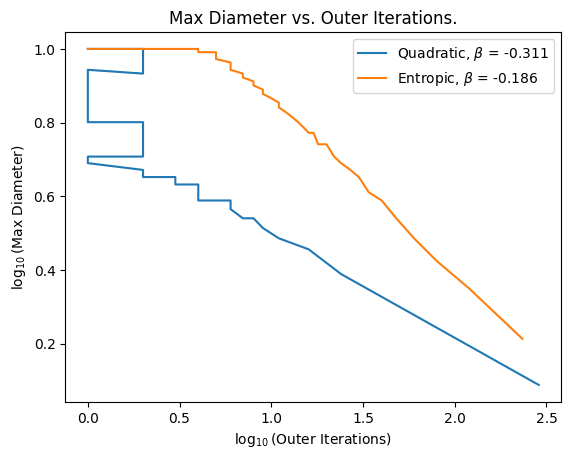

In [52]:
plt.figure()

xs_q = np.log10(np.array([distribution_outputs_quadratic[epsilon][4] for epsilon in epsilons_q]))
xs_e = np.log10(np.array([distribution_outputs_entropic[epsilon][4] for epsilon in epsilons_e]))

ys_q = np.log10(max_diams_quadratic)
ys_e = np.log10(max_diams_entropic)

var_x_q = np.mean(xs_q*xs_q) - np.mean(xs_q)**2
cov_q = np.mean(ys_q * xs_q) - np.mean(ys_q)*np.mean(xs_q)

var_x_e = np.mean(xs_e*xs_e) - np.mean(xs_e)**2
cov_e = np.mean(ys_e * xs_e) - np.mean(ys_e)*np.mean(xs_e)

beta_q = cov_q / var_x_q
beta_e = cov_e / var_x_e
plt.plot(xs_q, np.log10(max_diams_quadratic), label='Quadratic, $\\beta$ = %.3f'%beta_q)
plt.plot(xs_e, np.log10(max_diams_entropic), label='Entropic, $\\beta$ = %.3f'%beta_e)
plt.xlabel('$\\log_{10}$(Outer Iterations)')
plt.ylabel('$\\log_{10}$(Max Diameter)')
plt.title('Max Diameter vs. Outer Iterations.')
plt.legend()
plt.savefig('./plots/max_diamater_vs_outer_iterations.png', dpi=300)
plt.show()

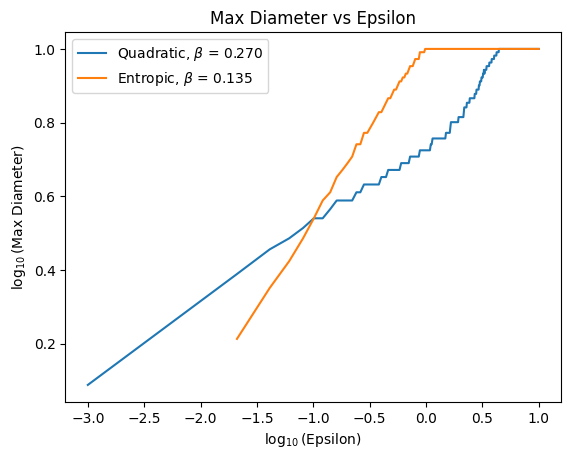

In [53]:
plt.figure()

xs_q = np.log10(epsilons_q)
xs_e = np.log10(epsilons_e)

ys_q = np.log10(max_diams_quadratic)
ys_e = np.log10(max_diams_entropic)

var_x_q = np.mean(xs_q*xs_q) - np.mean(xs_q)**2
var_x_e = np.mean(xs_e*xs_e) - np.mean(xs_e)**2

cov_q = np.mean(ys_q * xs_q) - np.mean(ys_q)*np.mean(xs_q)
cov_e = np.mean(ys_e * xs_e) - np.mean(ys_e)*np.mean(xs_e)

beta_q = cov_q / var_x_q
beta_e = cov_e / var_x_e
plt.plot(xs_q, np.log10(max_diams_quadratic), label='Quadratic, $\\beta$ = %.3f'%beta_q)
plt.plot(xs_e, np.log10(max_diams_entropic), label='Entropic, $\\beta$ = %.3f'%beta_e)
plt.xlabel('$\\log_{10}$(Epsilon)')
plt.ylabel('$\\log_{10}$(Max Diameter)')
plt.title('Max Diameter vs Epsilon')
plt.legend()
plt.savefig('./plots/epsilon_vs_max_diameter.png', dpi=300)
plt.show()